# Take Home Assignment 1

## Problem Statement
**What qualities of crude oil lead to pipeline accidents?**

Pipelines are generally regarded as a safe way to transport fuel, a far better alternative to tanker trucks or freight trains. But when a pipeline does fail, the consequences can be catastrophic; since 1986, pipeline accidents have killed more than 500 people, injured over 4,000 and cost nearly seven billion dollars in property damage. 

Using any resources available to you, can you determine *what phyisical chemical properties* of crude oil could be responsible for pipeline accidents?

---


### Scoping and Assumptions

For scope, we are going to focus on pipelines within Canada, this is both due to the relevance of the problem and due to the data availability. I addition, I am more familiar with the political and business landscape of Canada, which is important to consider for the second part of the question.

To tackle this question, first I will make some qualifying assumptions:

- We are going to assume all Canadian Crude has similar enough chemistry be considered as one product when analysing pipeline accidents
- We are going to assume that the differences in pipeline accident trends are primarily influenced by the properties of the material in conjunction with external factors (operator, location, weather conditions, etc.)

### Backgrounder - What is a pipeline accident?

To answer why pipeline accidents happen, first we have to figure out what we mean when we say "accident". We will start by analysing the [pipeline incident dataset](https://open.canada.ca/data/en/dataset/7dffedc4-23fa-440c-a36d-adf5a6cc09f1) provided by the National Energy Board. This will provide us of an idea of what kind of incidents occured during the reporting period (2008-2025). Given that this is a dataset of all pipelines, not just crude oil, we might also get some insight into how or why incidents concerning crude oil are different than other petrochemicals.

In [ ]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
from scipy.stats import chi2_contingency, spearmanr
import os
import warnings
warnings.filterwarnings('ignore')

In [16]:
#OS agnostic file path for importing the data
file_path = os.path.join('data','in','pipeline-incidents-comprehensive-data.csv')

df_raw = pd.read_csv(filepath_or_buffer= file_path,encoding='utf-8', encoding_errors='ignore')

In [ ]:
#start quantifying missing data for EDA
missing = df_raw.isnull().sum()
missing[missing>0]

Nearest Populated Centre                                                             2
Occurrence Date and Time                                                           458
Discovered Date and Time                                                             4
Detailed what happened                                                              27
Detailed why it happened                                                            28
                                                                                  ... 
Repair date                                                                       1743
Most recent inspection date for the failed equipment or component                 1626
Type of most recent inspection                                                    1627
Date of the most recent maintenance work for the failed equipment or component    1714
Most recent maintenance Type                                                      1668
Length: 66, dtype: int64

In [18]:
#do some data cleaning in the substances categories, this is not exactly perfect but good for a rough screen

df_raw['Substance carried'] = df_raw['Substance carried'].str.replace(r'.*Crude Oil.*', 'Crude Oil', regex=True)
df_raw['Substance carried'] = df_raw['Substance carried'].str.replace(r'.*Natural Gas.*', 'Natural Gas', regex=True)
df_raw['Substance carried'] = df_raw['Substance carried'].str.replace(r'^(?!.*(Crude Oil|Natural Gas)).*$', 'Other', regex=True)


#while there are other ways to interpolate data - for this project we are only going to look at pipelines where we know what they are carrying for sure
df = df_raw[df_raw['Substance carried'].notnull()].copy()

<Axes: title={'center': 'Pipeline Incidents (2008-2025)'}, xlabel='Number of Incidents', ylabel='Substance carried'>

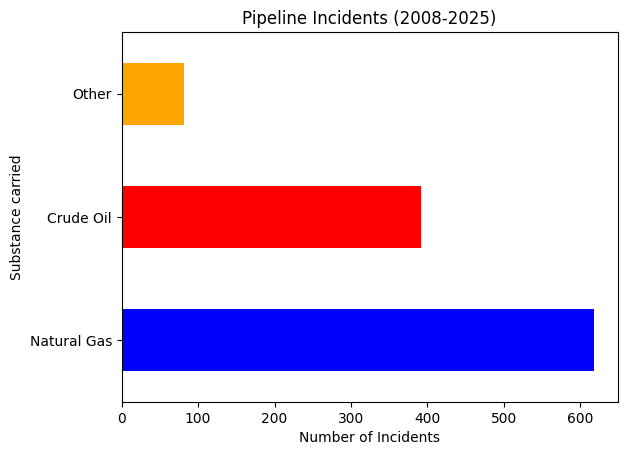

In [78]:
#plot distribution of pipeline incidents by type of substance carried
df['Substance carried'].value_counts().plot(xlabel='Number of Incidents',kind='barh', facecolor=['blue','red','orange'], title = 'Pipeline Incidents (2008-2025)')

After some data cleaning we observe that over the last ~20 years the majority of pipeline related incidents have been from pipelines carrying natural gas, while about 35% of the incidents have been in pipelines transporting crude oil. 

In [20]:
incident_counts = df['Incident Types'].value_counts(dropna=False)
incident_counts

Incident Types
Release of Substance                                   339
Operation Beyond Design Limits                         321
Fire                                                   260
Serious Injury (CER)                                    84
Adverse Environmental Effects                           59
Explosion                                               11
Fire, Release of Substance                               4
Explosion, Fire, Release of Substance                    3
Fatality                                                 3
Release of Substance, Adverse Environmental Effects      3
Explosion, Fire                                          2
Serious Injury (CER), Fire                               1
Name: count, dtype: int64

In [21]:
#drop some of the uncommon incidents to make results a bit more interpretable
valid_incidents = incident_counts[incident_counts>=5].index
df_incidents = df[df['Incident Types'].isin(valid_incidents)].copy()

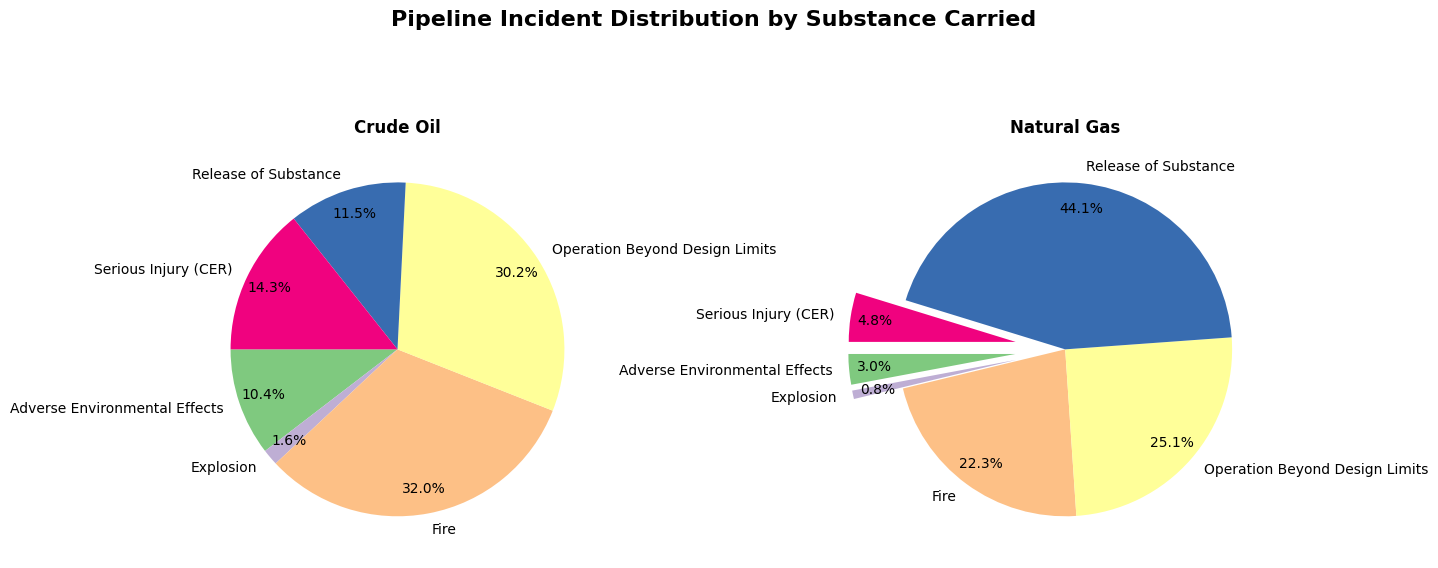

In [22]:
#compare the incident frequency by substance carried
colours = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']

pivot_df = pd.crosstab(df_incidents['Substance carried'], df_incidents['Incident Types'])


fig, axes = plt.subplots(1, 2, figsize=(14, 7))

#pie chart for crude oil
pivot_df.loc['Crude Oil'].plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=180, colors=colours,labeldistance=1.1, pctdistance=0.85)
axes[0].set_title('Crude Oil',fontweight='bold')
axes[0].set_ylabel('')

#pie chart for natural gas
pivot_df.loc['Natural Gas'].plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=180, colors=colours,labeldistance=1.1, pctdistance=0.85, explode = [0.3,0.3,0,0,0,0.3])
axes[1].set_title('Natural Gas',fontweight='bold')
axes[1].set_ylabel('')

fig.suptitle('Pipeline Incident Distribution by Substance Carried',fontsize=16, fontweight = 'bold')
fig.subplots_adjust(wspace=0.6)


plt.show()

In [23]:
pivot_df_other = pd.crosstab(df_incidents['Incident Types'],df_incidents['Substance carried'])
pivot_df_other.drop(columns = 'Other', inplace=True)
pivot_df_other

Substance carried,Crude Oil,Natural Gas
Incident Types,,
Adverse Environmental Effects,40,18
Explosion,6,5
Fire,123,136
Operation Beyond Design Limits,116,153
Release of Substance,44,269
Serious Injury (CER),55,29


So considering the breakdown of pipeline incidents, the majority of incidents are either Operation Beyond Design Limits or Fire. To test that the distribution of accidents is related to the type of substance in the pipeline, we will perform a simple chi squared test, where the null hypothesis of a chi-squared test is that there is no association between the material carried in the pipeline, and the incident types that occur.

In [24]:
#test if there is a significant difference between carrying crude oil in a pipeline in terms of accidents and carrying natural gas

#perform chi-square test
chi2, p, dof, expected = chi2_contingency(pivot_df_other)

print(f"chi-square statistic: {chi2}")
print(f"p value: {p}")
print(f"degrees of freedom: {dof}")
#print("expected frequencies:")
#print(expected)


# fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# #plot the observed data
# sns.heatmap(pivot_df_other, annot=True, cmap="Blues", ax=ax[0])
# ax[0].set_title("Observed Frequencies")

# #plot expected frequencies from chi-squared test
# sns.heatmap(expected, annot=True, cmap="Blues", ax=ax[1])
# ax[1].set_title("Expected Frequencies")

# plt.tight_layout()
# plt.show()


chi-square statistic: 139.8093642921533
p value: 1.9642225873981928e-28
degrees of freedom: 5


The p value for the test is much less than 0.05, so we can safely reject the null hypothesis. In other words, there is a dependency between the kind of pipeline incident, and the material that the pipeline is carrying! This, in part, validates our second assumption.


---

### Cause analysis for pipeline incidents

With some correlation established between the type of product and the distribution of incidents, we will now move forward to understanding what is the cause of each of these incident typesm and how to correlate them to the materials properties of crude oil.

#### 1A. Operation Beyond Design Limits

First let's look into the most common incident for crude oil pipelines

In [25]:
#parse the reporting for what conditions caused the incident
df[(df['Substance carried']=='Crude Oil')&(df['Incident Types']=='Operation Beyond Design Limits')]['Conditions that resulted in the operation beyond  limits'].value_counts()


Conditions that resulted in the operation beyond  limits
Over Pressure                                52
Exposed Pipe                                 42
Exposure in a Waterbody                      14
Overpressure - Maximum Operating Pressure     5
Slope Movements                               2
Exposure on Land                              1
Name: count, dtype: int64

While several of these cases are likely independent of the chemical properties of the substance carried in the pipeline (e.g. exposed pipe or exposure in a waterbody), over pressure could potentially be related to the chemical properties of crude oil. So what causes Over pressure in crude oil pipelines?


Overpressure can be caused by several factors, but one of the most common causes is pipeline **obstruction by the debris or solids**, such as the formation of **crude oil hydrates** (when reacted with water), and other generally soluble components crystalizing out of solution. Typicially the conditions that are necessary for this type of formation are:
1. the presence of water
2. high pressure
3. low temperature

[source](https://pmc.ncbi.nlm.nih.gov/articles/PMC9366985)

Given that all pipelines operate as pressurized systems (to transport fluid at long distances) and it is nearly impossible to remove all water from industrial processes, the last variable to consider is the temperature.

If hydrate formation is causing pipeline over pressure, we would expect a seasonal correlation in the reporting dates


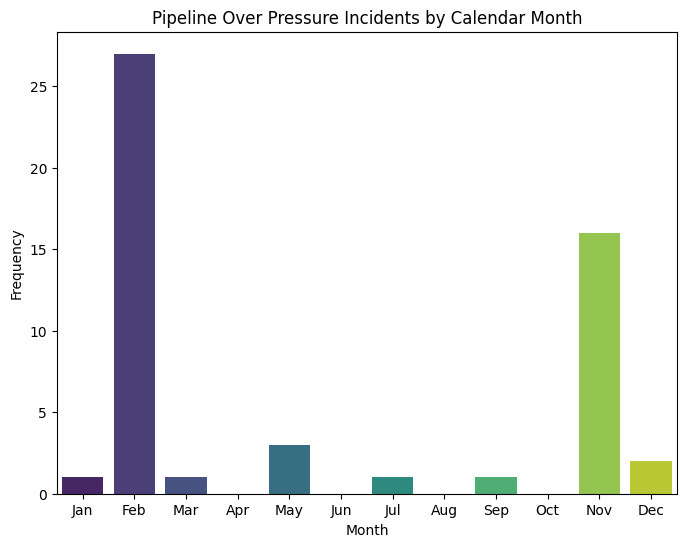

In [26]:
reported_dates = df[(df['Substance carried']=='Crude Oil')&(df['Incident Types']=='Operation Beyond Design Limits')&(df['Conditions that resulted in the operation beyond  limits']=='Over Pressure')]['Reported Date'].copy()

datetime_dates = pd.to_datetime(reported_dates, format = '%m/%d/%Y')
months = datetime_dates.dt.month
month_counts = months.value_counts().sort_index()
month_counts = month_counts.reindex(range(1, 13), fill_value=0)


plt.figure(figsize=(8, 6))
sns.barplot(x=month_counts.index, y=month_counts.values, palette="viridis")
plt.title('Pipeline Over Pressure Incidents by Calendar Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


The majority of the over pressure incidents do co-incide with winter months, especially those with more highly variable daily temperatures. Checking the historical weather data across some of the outliers, July 30, 2016 and May 7, 2017 were both days that experienced uncharacteristically cold periods where the ambient temperature dropped below 15 degrees celsuis, which are conditions that enable hydrate formation. 

Taken together we can attribute crude oil hydrate formation to the majority of over pressure incidents.

#### 1B. Potential solutions to limit hydrate formation and their business impacts

<ins>Policy Options and Business Impact</ins>

Three potential policy options to limit or reduce crude oil pipeline over pressure incidents are:

1. Implement or increase minimum concentration for hydrate inhibiting additives (e.g. methanol).
2. Implement or increase the insulation requirements for pipelines (all of the pipelines experiencing over pressure were not insulated).
3. Reduce the maximum operating pressure for crude oil pipelines.


Of all of these policy solutions the simplest to implement would be reducing the maximum operating pressure for crude oil carrying pipelines, though this may have some added negatives of reducing the flow rate of the oil through the pipeline, which in turn would increase the minimum temperature for hydrate formation. Because this trade off is not clear, and would be influenced by the parameters of each individual pipeline (based on the geometry of the pipeline) - I would not recommend this solution. In addition, this reduced flow rate would reduce the throughput of a give pipeline, lowering oil output. This lowered output has the potential to reduce the competitiveness of Canadian or North American oil products, as supply gaps could potentially be filled by extraction operations in other countries. That being said if the supply could not be easily increased then the impact on oil markets would potentially be the increase in oil prices as a function of scarcity - offseting the immediate revenue reductions that one would expect with lower oil pipeline throughput.

Between policy options 1 and 2, I would suggest **option 1, implementing or increasing the minimum hydrate inhibiting additive concentration**. While option 2 is attractive due to it's simplicity and limited increases to operating costs, insulating hundreds and hundreds of kilometers of pipelines is both extremely capital intensive, will require additional operational maintenance, and will make it more challenging to visually inspect pipelines for other signs of wear (such as corrosion). Additional additives to crude oil could easily be injected using existing machinery in pipelines, such as those that are currently used to incorporate drag reducing agents. From a business perspective this would increase the operating costs of crude oil pipelines, thereby reducing the profit per volume, but these operating costs could be offset in two ways. First, by reducing the formation of hydrates, pipelines would remain unobstructed, enabling them to operate at peak throughput for longer periods of time. Second, if methanol were to be used, methanol is a value added product that is commonly produced as a byproduct of carbon dixoide capture (via the reduction of carbon dioxide to methanol). So such a system could be pair with carbon capture and sequestration systems which could qualify for government incentives and reduce the carbon tax burden on canadian pipeline operation.





<ins>Have we gotten better at regulating these properties and how can we measure success?</ins>

To determine if we have improved at regulating hydrate formation that causes overpressure over time, we can look at the correlation between the frequency of overpressure incidents over time. To do this we will compute Spearman's $\rho$ coefficient for the last 10 years of incident data, which will indicate if the number of incidents has reduced over time. Spearman's $\rho$ is a bit more robust than the more popular Pearson's R as it does not assume a linear relationship between variables.


Text(0.5, 1.0, 'Annual Frequency of Pipeline Over Pressure Incidents')

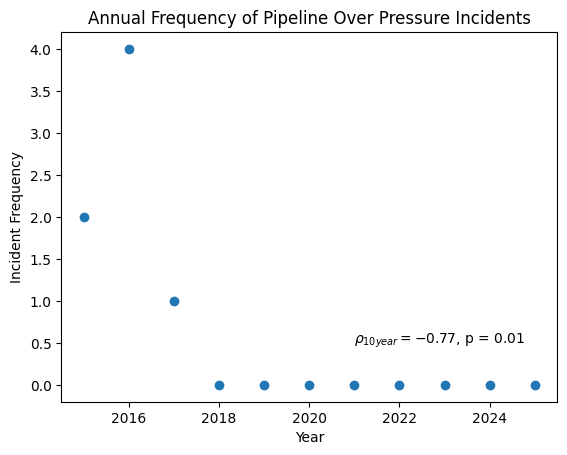

In [77]:
crude_oil_date_counts = datetime_dates.dt.year.value_counts(sort=False).sort_index()
crude_oil_date_counts = crude_oil_date_counts.reindex(range(2015,2026),fill_value=0)

rho, p = spearmanr(crude_oil_date_counts.index,crude_oil_date_counts)

plt.scatter(x=crude_oil_date_counts.index, y=crude_oil_date_counts.values)

rho_text = r'$\rho_{10year} = %.2f$' % rho + r', p = %.2f' % p

plt.annotate(rho_text, (crude_oil_date_counts.index[-2]-3,crude_oil_date_counts.values[-2]+0.5))
plt.xlabel('Year')
plt.ylabel('Incident Frequency')
plt.title('Annual Frequency of Pipeline Over Pressure Incidents')


After computing Spearman's $\rho$ we can conclude that the number of over pressure incidents in the last 10 years has reduced dramatically (a $\rho$ near -1) and significantly (p < 0.05). We can similarly compute these statistical measures over various time periods to measure the shorter and longer term sucess of a policy intervention.

Some other metrics that could be implemented to measure success on the shorter term are:
1. Daily pipeline flow volume
2. Day over day pressure increase
3. Temperature-Pressure dependence over time

These values could be compared with historical data, where a Student's T test could be employed to measure deviation from historical, and statistically significant changes would indicate the success of an intervention, and the size of the change would indicate the level of success.


#### 2A. Fire

In [27]:
#instantiate map and get center
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
pipeline_map = fm.Map(location=map_center, zoom_start=3.5)

#plot incidents on map
for _, row in df[(df['Substance carried']=='Crude Oil')&(df['Incident Types']=='Operation Beyond Design Limits')].iterrows():
    fm.Marker([row['Latitude'], row['Longitude']]).add_to(pipeline_map)

display(pipeline_map)